#Import Libraries

In [72]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta
import warnings

#Generate mock sales data

In [5]:
np.random.seed(42)
start_date = datetime(2020, 1, 1)
num_months = 48 # 4 years of monthly data
date_rng = pd.date_range(start_date, periods=num_months, freq='MS') # MS for Month Start
sales_data = pd.DataFrame(date_rng, columns=['Date'])

Base sales with a slight upward trend

In [6]:
base_sales = 10000 + np.arange(num_months) * 50

Seasonal component (higher in Q4, lower in Q1)

In [7]:
seasonal_component = 2000 * np.sin(2 * np.pi * (sales_data['Date'].dt.month - 1) / 12 + np.pi/2) \
+ 1500 * np.sin(2 * np.pi * (sales_data['Date'].dt.month - 1) / 6)

Random noise

In [8]:
noise = np.random.normal(0, 500, num_months)
sales_data['SalesAmount'] = (base_sales + seasonal_component + noise).astype(int)
sales_data['SalesAmount'] = sales_data['SalesAmount'].clip(lower=2000) # Ensure sales are positive

Add promotional flags (randomly)

In [10]:
sales_data['Promotion'] = np.random.choice([0, 1], num_months, p=[0.8, 0.2])
sales_data.loc[sales_data['Promotion'] == 1, 'SalesAmount'] *= np.random.uniform(1.1, 1.3) # Increase sales during promotion

Add holiday flags (e.g., December)

In [11]:
sales_data['HolidayMonth'] = (sales_data['Date'].dt.month == 12).astype(int)
sales_data.loc[sales_data['HolidayMonth'] == 1, 'SalesAmount'] *= np.random.uniform(1.15, 1.4) # Increase sales during holiday month
sales_data['SalesAmount'] = sales_data['SalesAmount'].astype(int)

Save to CSV

In [12]:
sales_data.to_csv('retail_sales_mock_data.csv', index=False)
sales_data.head(10)

,Date,SalesAmount,Promotion,HolidayMonth
0,2020-01-01,15021,1,0
1,2020-02-01,13011,0,0
2,2020-03-01,15603,1,0
3,2020-04-01,17208,1,0
4,2020-05-01,7783,0,0
5,2020-06-01,11199,1,0
6,2020-07-01,9089,0,0
7,2020-08-01,12632,1,0
8,2020-09-01,12833,1,0
9,2020-10-01,13786,0,0


#Data Exploration and Preparation

Convert 'Date' to datetime and set as index

In [13]:
sales_data['Date'] = pd.to_datetime(sales_data['Date'])
sales_data.set_index('Date', inplace=True)

Check for missing values

In [15]:
print("Missing Values:\n", sales_data.isnull().sum())

Missing Values:
 SalesAmount     0
Promotion       0
HolidayMonth    0
dtype: int64


Plot Sales Over Time

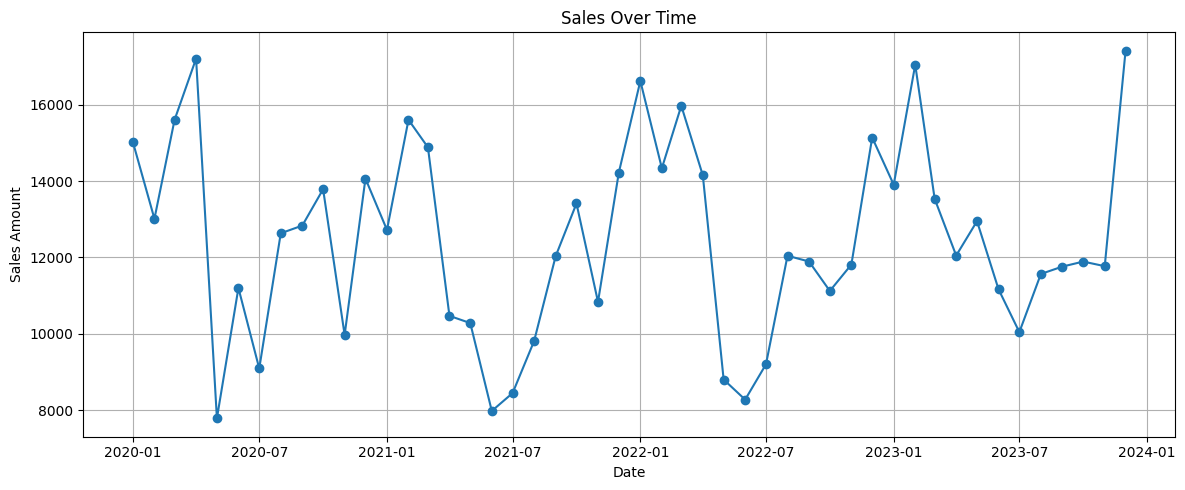

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(sales_data.index, sales_data['SalesAmount'], marker='o', linestyle='-')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.grid(True)
plt.tight_layout()
plt.show()

Seasonal Decomposition (Additive Model)

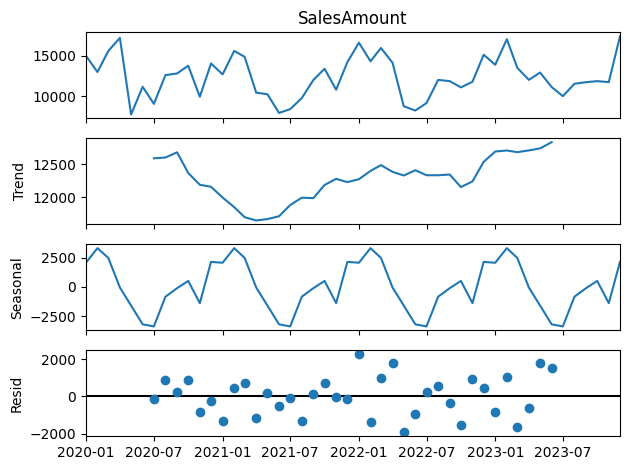

In [21]:
decomposition = seasonal_decompose(sales_data['SalesAmount'], model='additive', period=12)
decomposition.plot()
plt.tight_layout()
plt.show()

ACF and PACF Plots

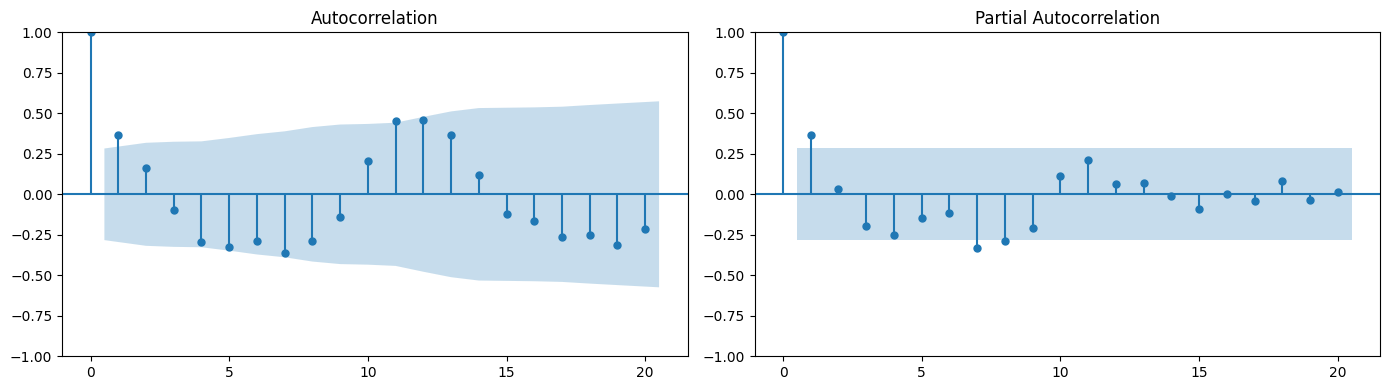

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(sales_data['SalesAmount'], ax=axes[0], lags=20)
plot_pacf(sales_data['SalesAmount'], ax=axes[1], lags=20)
plt.tight_layout()
plt.show()

Augmented Dickey-Fuller Test

In [25]:
result = adfuller(sales_data['SalesAmount'])
print("Augmented Dickey-Fuller Test Results")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

if result[1] < 0.05:
    print("\n The series is stationary.")
else:
    print("\n The series is not stationary.")

Augmented Dickey-Fuller Test Results
ADF Statistic: -1.1006466314121686
p-value: 0.7148139671457587
Critical Value (1%): -3.6209175221605827
Critical Value (5%): -2.9435394610388332
Critical Value (10%): -2.6104002410518627

 The series is not stationary.


#Feature Engineering

Create Lag Features (previous month sales)

In [32]:
sales_data['lag_1'] = sales_data['SalesAmount'].shift(1)
sales_data['lag_2'] = sales_data['SalesAmount'].shift(2)
sales_data['lag_3'] = sales_data['SalesAmount'].shift(3)

Create Rolling Features (optional for smoothing trends)

In [33]:
sales_data['rolling_mean_3'] = sales_data['SalesAmount'].rolling(window=3).mean()
sales_data['rolling_std_3'] = sales_data['SalesAmount'].rolling(window=3).std()

In [34]:
sales_data['Holiday_and_Promo'] = sales_data['HolidayMonth'] * sales_data['Promotion']

In [35]:
sales_data.head()

,SalesAmount,Promotion,HolidayMonth,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,Holiday_and_Promo
Date,,,,,,,,,
2020-01-01,15021,1,0,NaN,NaN,NaN,NaN,NaN,0
2020-02-01,13011,0,0,15021.0,NaN,NaN,NaN,NaN,0
2020-03-01,15603,1,0,13011.0,15021.0,NaN,14545.000000,1359.980882,0
2020-04-01,17208,1,0,15603.0,13011.0,15021.0,15274.000000,2117.754235,0
2020-05-01,7783,0,0,17208.0,15603.0,13011.0,13531.333333,5042.470459,0


Drop rows with NaN introduced by lag/rolling

In [36]:
sales_data.dropna(inplace=True)

In [37]:
sales_data.head()

,SalesAmount,Promotion,HolidayMonth,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,Holiday_and_Promo
Date,,,,,,,,,
2020-04-01,17208,1,0,15603.0,13011.0,15021.0,15274.000000,2117.754235,0
2020-05-01,7783,0,0,17208.0,15603.0,13011.0,13531.333333,5042.470459,0
2020-06-01,11199,1,0,7783.0,17208.0,15603.0,12063.333333,4771.578390,0
2020-07-01,9089,0,0,11199.0,7783.0,17208.0,9357.000000,1723.697189,0
2020-08-01,12632,1,0,9089.0,11199.0,7783.0,10973.333333,1782.247551,0


#Model Selection and Training for Time Series

Select target variable

In [47]:
y = sales_data['SalesAmount']

Train-validation split (last 6 months for validation)

In [48]:
train = y[:-6]
valid = y[-6:]
print(f"Train shape: {train.shape}")
print(f"Validation shape: {valid.shape}")

Train shape: (39,)
Validation shape: (6,)


Tune SARIMA (p,d,q)(P,D,Q,s)

In [64]:
p = d = q = range(0, 2)  # try (0, 1)
seasonal_pdq = list(itertools.product(p, d, q))
seasonal_period = 12

best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

print("Tuning SARIMA (smaller grid)")

for order in seasonal_pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(train,
                            order=order,
                            seasonal_order=(seasonal_order[0],
                                            seasonal_order[1],
                                            seasonal_order[2],
                                            seasonal_period),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = results
        except Exception as e:
            print(f"Failed: order={order}, seasonal_order={seasonal_order}, error={e}")
            continue

print(" Best SARIMA order:", best_order)
print(" Best Seasonal order:", best_seasonal_order, "with AIC:", best_aic)

Tuning SARIMA (smaller grid)
 Best SARIMA order: (0, 1, 1)
 Best Seasonal order: (1, 1, 1) with AIC: 215.36924857743628


In [73]:
model = SARIMAX(train,
                order=(0, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
result = model.fit()


Forecast

In [75]:
forecast = result.predict(start=valid.index[0], end=valid.index[-1], dynamic=False)

Evaluate

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
mae = mean_absolute_error(valid, forecast)
rmse = np.sqrt(mean_squared_error(valid, forecast))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 1543.50
RMSE: 2064.88


Plot Forecast vs Actual

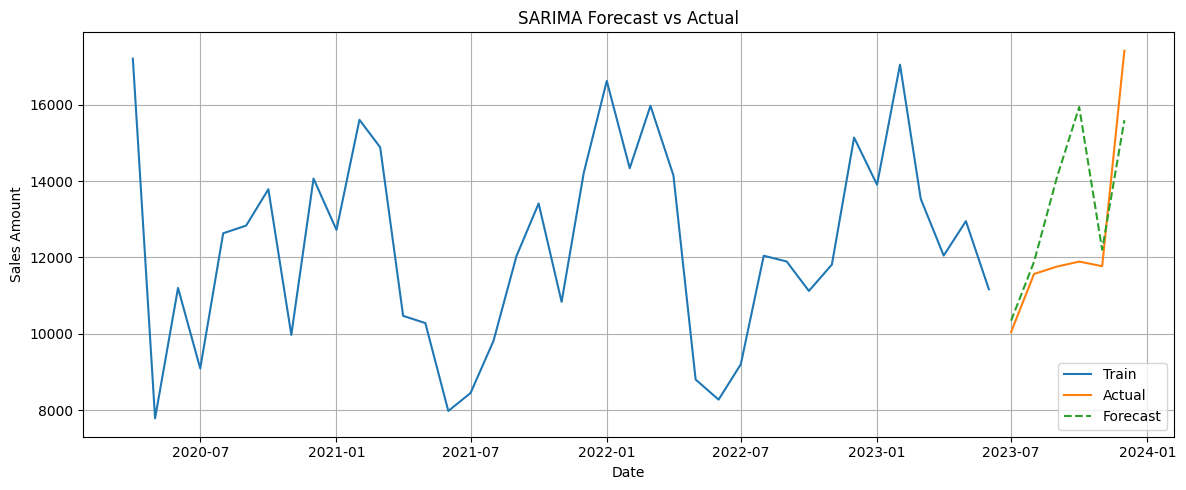

In [77]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label="Train")
plt.plot(valid.index, valid, label="Actual")
plt.plot(valid.index, forecast, label="Forecast", linestyle="--")
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Model Evaluation and Forecasting using SARIMA

Evaluation on Validation Set

In [79]:
# Actual values
actual = valid
# Predicted values
predicted = forecast

Evaluation Metrics

In [80]:
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print(f"MAE  = {mae:.2f}")
print(f"MSE  = {mse:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")

MAE  = 1543.50
MSE  = 4263743.75
RMSE = 2064.88
MAPE = 12.30%


Retrain Best Model on Full Dataset

In [81]:
full_model = SARIMAX(y,
                     order=(0, 1, 1),
                     seasonal_order=(1, 1, 1, 12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
full_result = full_model.fit()

Forecast for Next 6 Months (with confidence intervals)

In [82]:
n_periods = 6
forecast_result = full_result.get_forecast(steps=n_periods)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

last_date = y.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_periods, freq='MS')
forecast_mean.index = future_dates
conf_int.index = future_dates


Plot Future Forecast with Confidence Intervals

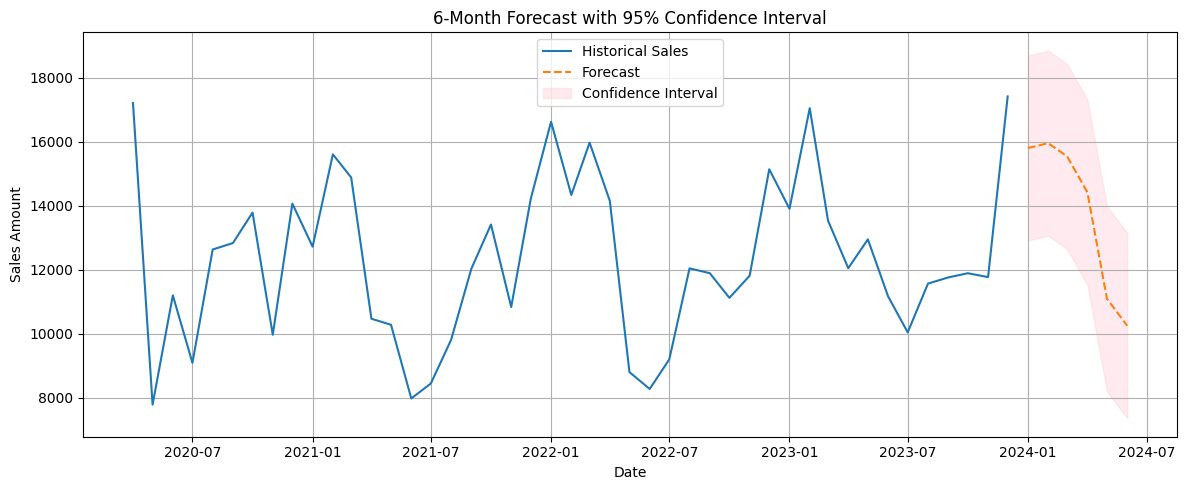

In [83]:
plt.figure(figsize=(12, 5))
plt.plot(y, label="Historical Sales")
plt.plot(forecast_mean, label="Forecast", linestyle="--")
plt.fill_between(forecast_mean.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label="Confidence Interval")
plt.title("6-Month Forecast with 95% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()